In [2]:
# Notebook setup (segment pipeline) / Notebook 初始化（segment 管线）
import os
from pathlib import Path
import sqlite3
import sys
import pandas as pd

def _find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "pyproject.toml").exists() and (p / "src" / "airline_revenue_analytics").exists():
            return p
    return start

try:
    from airline_revenue_analytics.config import get_paths
except ModuleNotFoundError:
    # Fall back to src/ on sys.path for notebook runs.
    repo_root = _find_repo_root(Path.cwd())
    src_root = repo_root / "src"
    if str(src_root) not in sys.path:
        sys.path.append(str(src_root))
    try:
        from airline_revenue_analytics.config import get_paths
    except ModuleNotFoundError as exc:
        raise ModuleNotFoundError("Install the package first: pip install -e .") from exc

# Resolve repo paths and DB location / 解析仓库路径与数据库位置
paths = get_paths("segment")
REPO_ROOT = paths.repo_root
DATA_DIR = paths.data_raw
OUT_DIR = paths.outputs_root
FIG_DIR = paths.figures
TAB_DIR = paths.tables
ART_DIR = paths.artifacts
DB_PATH = paths.db_path
db_path = DB_PATH

# SQLite connection (shared across cells) / SQLite 连接（全局复用）
conn = sqlite3.connect(DB_PATH)

def _rel(p: Path) -> str:
    """Render repo-relative paths for display / 将路径显示为仓库相对路径."""
    try:
        return str(Path(p).resolve().relative_to(REPO_ROOT))
    except Exception:
        return str(p)

def find_path(filename: str) -> Path:
    """Locate a file under outputs/ or data/raw / 在 outputs/ 或 data/raw 中定位文件."""
    for p in (OUT_DIR / filename, DATA_DIR / filename, REPO_ROOT / filename):
        if p.exists():
            return p
    for root, _, files in os.walk(OUT_DIR):
        if filename in files:
            return Path(root) / filename
    raise FileNotFoundError(
        f"Cannot find {filename}. Put it under data/raw or outputs/segment."
    )


In [3]:
from airline_revenue_analytics.viz.charts import apply_style, PLOT_COLORS
apply_style()
PASS_COLOR = "#D9F2E6"
FAIL_COLOR = "#FCE4E4"
NEG_BG_COLOR = FAIL_COLOR


[Loaded] rows=574,830, num_cols=6, cat_cols=3


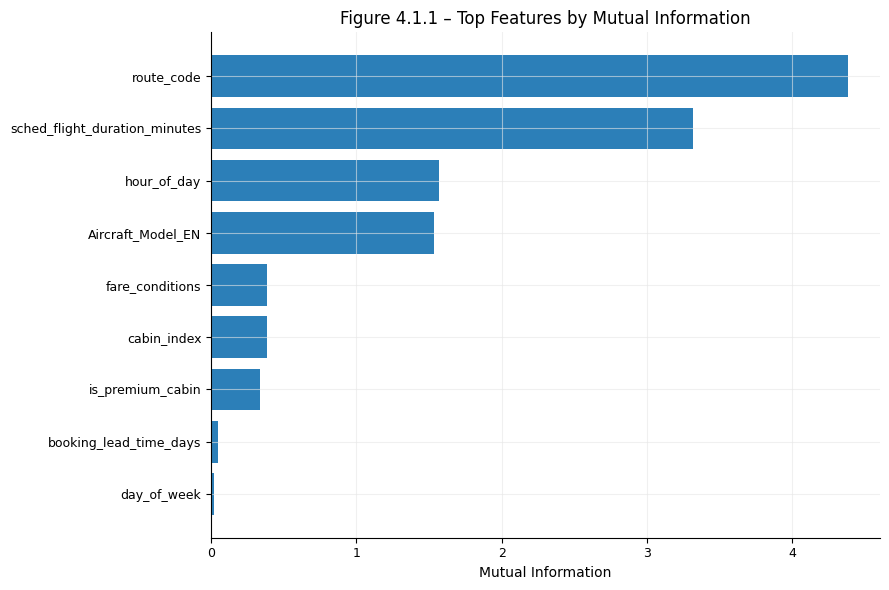

Saved: figures/figure_4_1_1_mi.png, tables/table_4_1_0_mutual_information_all.csv


In [4]:
import os, numpy as np, pandas as pd
from pandas.api.types import is_datetime64_any_dtype

if "X" not in globals() or "y" not in globals():
    X = pd.read_parquet(find_path("X_features.parquet"))
    y = pd.read_parquet(find_path("y_target.parquet")).squeeze()
    y = pd.to_numeric(y, errors="coerce")

    dt_cols = [c for c in X.columns if is_datetime64_any_dtype(X[c])]
    if dt_cols:
        X = X.drop(columns=dt_cols)

    for c in X.select_dtypes(include=["boolean", "bool"]).columns:
        X[c] = X[c].astype("int16")

    nullable_ints = [c for c in X.columns if str(X[c].dtype).startswith(("Int", "UInt"))]
    for c in nullable_ints:
        X[c] = X[c].astype("float64")

    num_cols = list(X.select_dtypes(include=["number"]).columns)
    cat_cols = [c for c in X.columns if c not in num_cols]

    print(f"[Loaded] rows={len(X):,}, num_cols={len(num_cols)}, cat_cols={len(cat_cols)}")

import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_regression

# Sampling for speed (adjustable) / 为了速度做抽样（可调）
def subsample(df, n): 
    return df.sample(n=min(n, len(df)), random_state=42)

X_mi = subsample(X, 100_000)
y_mi = y.loc[X_mi.index]

pre_mi = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("enc", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
    ]), cat_cols)
], remainder="drop", sparse_threshold=0)

Xm = pre_mi.fit_transform(X_mi)
mi_scores = mutual_info_regression(Xm, y_mi, random_state=42)
mi_names  = num_cols + cat_cols

mi_df = (pd.DataFrame({"feature": mi_names, "MI": mi_scores})
         .sort_values("MI", ascending=False).reset_index(drop=True))
mi_df.to_csv(TAB_DIR/"table_4_1_0_mutual_information_all.csv", index=False)

# Top-20 条形图
topk = 20
mi_top = mi_df.head(topk)
plt.figure(figsize=(9, 6))
plt.barh(mi_top["feature"][::-1], mi_top["MI"][::-1])
plt.xlabel("Mutual Information")
plt.title("Figure 4.1.1 – Top Features by Mutual Information")
plt.tight_layout(); plt.savefig(FIG_DIR/"figure_4_1_1_mi.png", dpi=220); plt.show()

print("Saved: figures/figure_4_1_1_mi.png, tables/table_4_1_0_mutual_information_all.csv")


In [5]:
%matplotlib inline

import os, numpy as np, pandas as pd, matplotlib
from matplotlib import pyplot as plt
from IPython.display import display, Image

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

from pandas.api.types import is_datetime64_any_dtype

# 强制使用 Jupyter 内嵌后端并提高清晰度
try:
    import matplotlib_inline.backend_inline as _mi
    _mi.set_matplotlib_formats('retina')
except Exception:
    pass

FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

# Load features and target / 读取特征与目标
X = pd.read_parquet(find_path("X_features.parquet"))
y = pd.read_parquet(find_path("y_target.parquet")).squeeze()
y = pd.to_numeric(y, errors="coerce")

# —— 清理 dtype：去掉 datetime，布尔转 int，pandas nullable 整数转 float
dt_cols = [c for c in X.columns if is_datetime64_any_dtype(X[c])]
if dt_cols:
    X = X.drop(columns=dt_cols)

for c in X.select_dtypes(include=["boolean", "bool"]).columns:
    X[c] = X[c].astype("int16")

nullable_ints = [c for c in X.columns if str(X[c].dtype).startswith(("Int", "UInt"))]
for c in nullable_ints:
    X[c] = X[c].astype("float64")

num_cols = list(X.select_dtypes(include=["number"]).columns)
cat_cols = [c for c in X.columns if c not in num_cols]

print(f"[Loaded] rows={len(X):,}, num_cols={len(num_cols)}, cat_cols={len(cat_cols)}")

# Train/test split + sampling helpers (for speed) / 训练/测试划分 + 采样函数（加速用）
rng = np.random.RandomState(42)
def subsample(df, n, seed=42):
    return df.sample(n=min(n, len(df)), random_state=seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# 版本兼容的一次性 OneHotEncoder
try:
    _ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    _ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

pre_rf = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", _ohe)
    ]), cat_cols)
], remainder="drop")

rf = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
pipe_rf = Pipeline([("pre", pre_rf), ("rf", rf)])


[Loaded] rows=574,830, num_cols=6, cat_cols=3


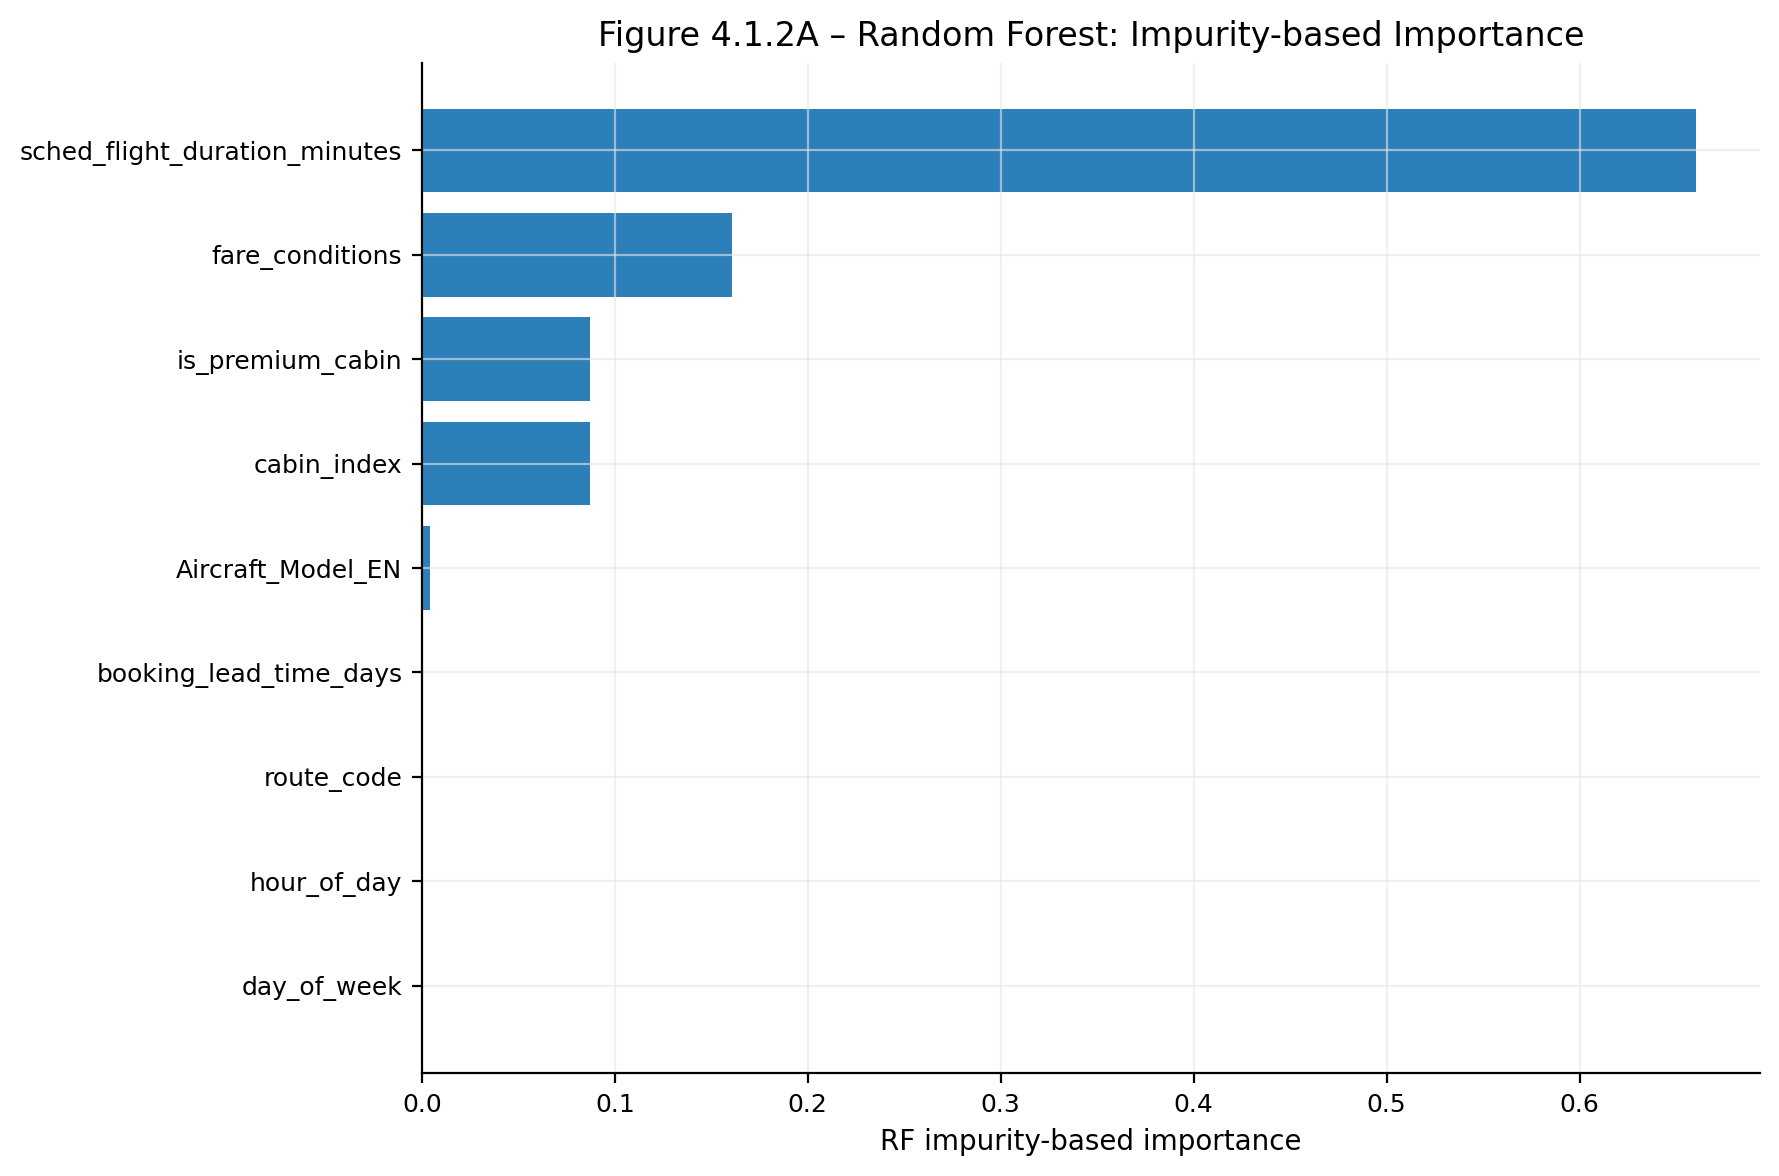

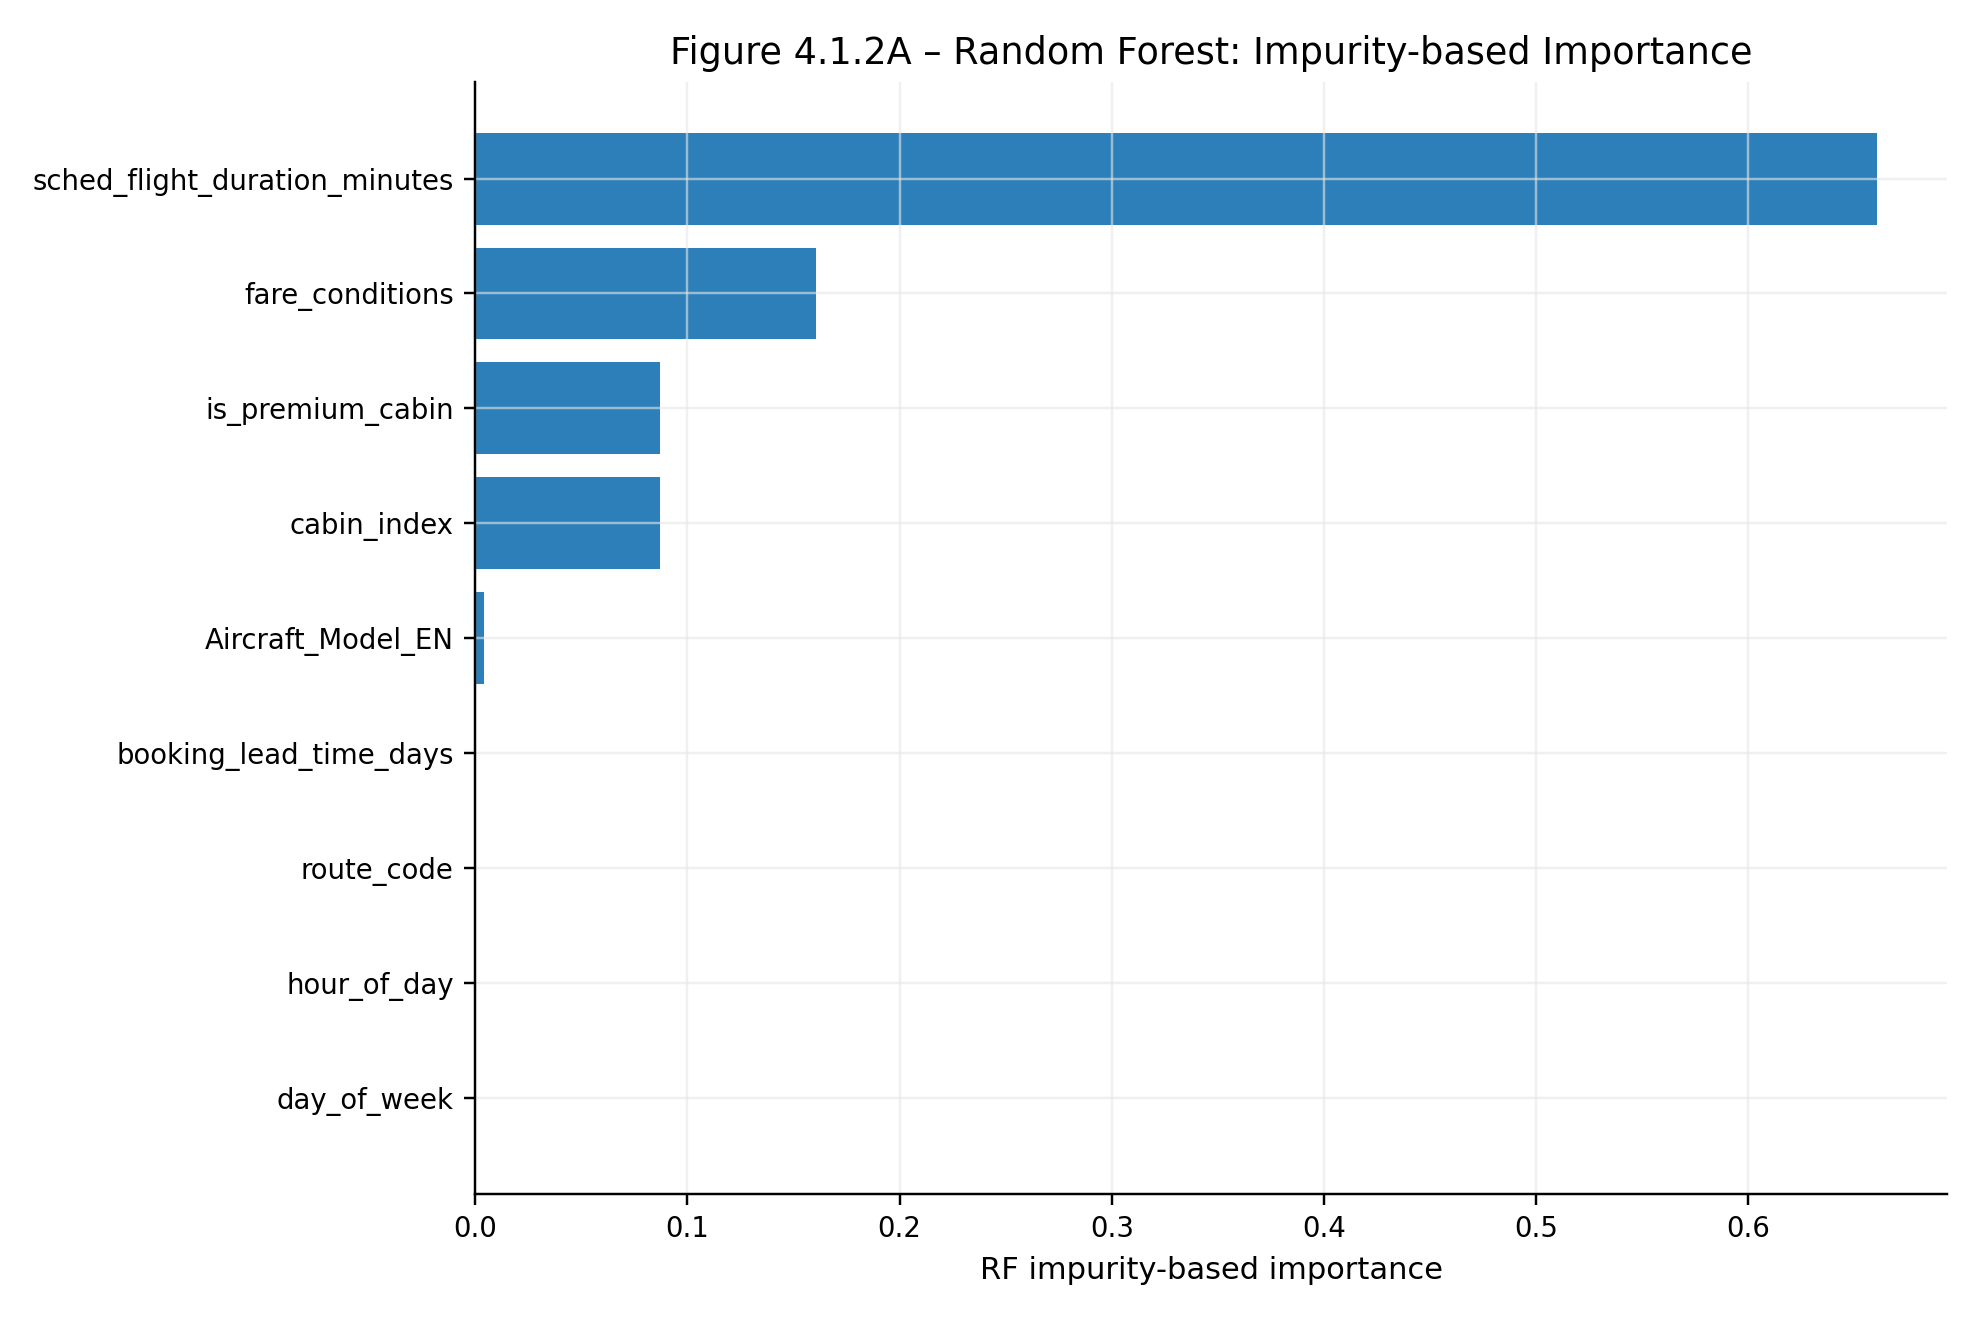

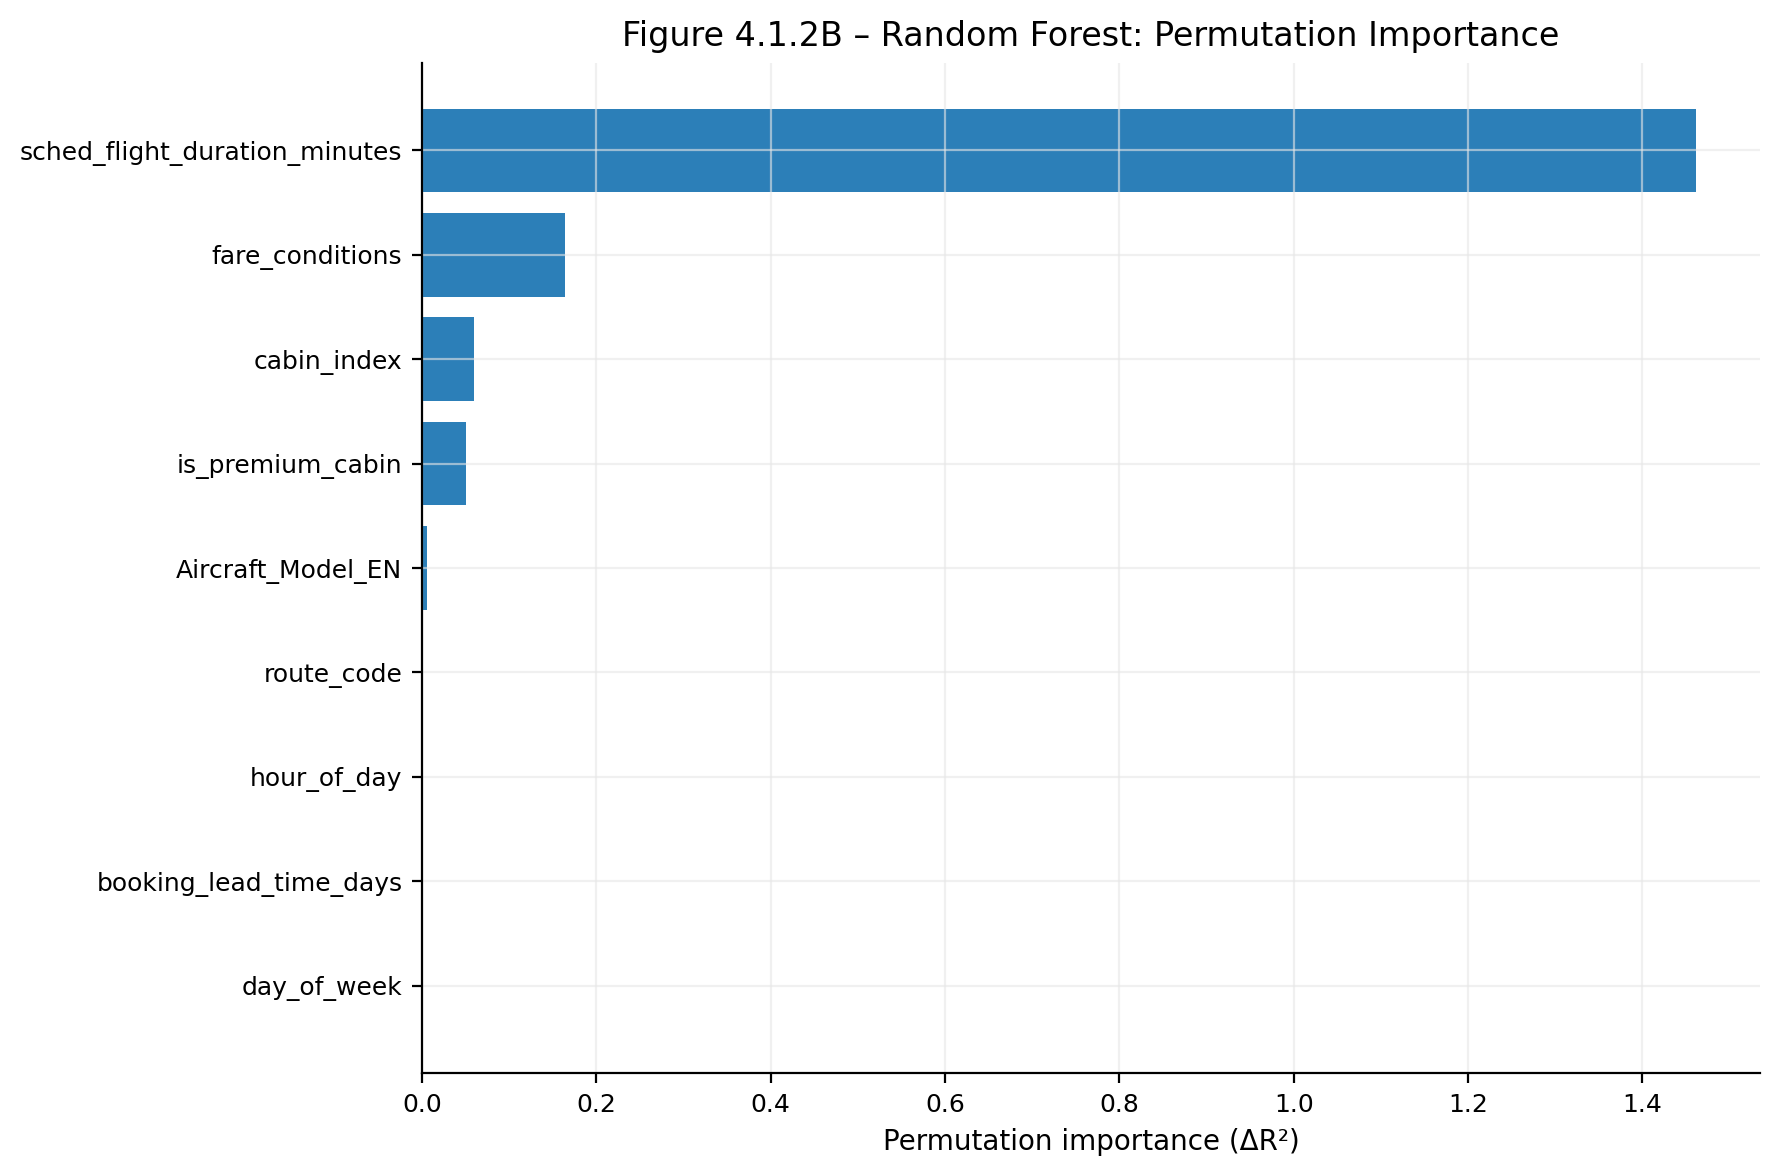

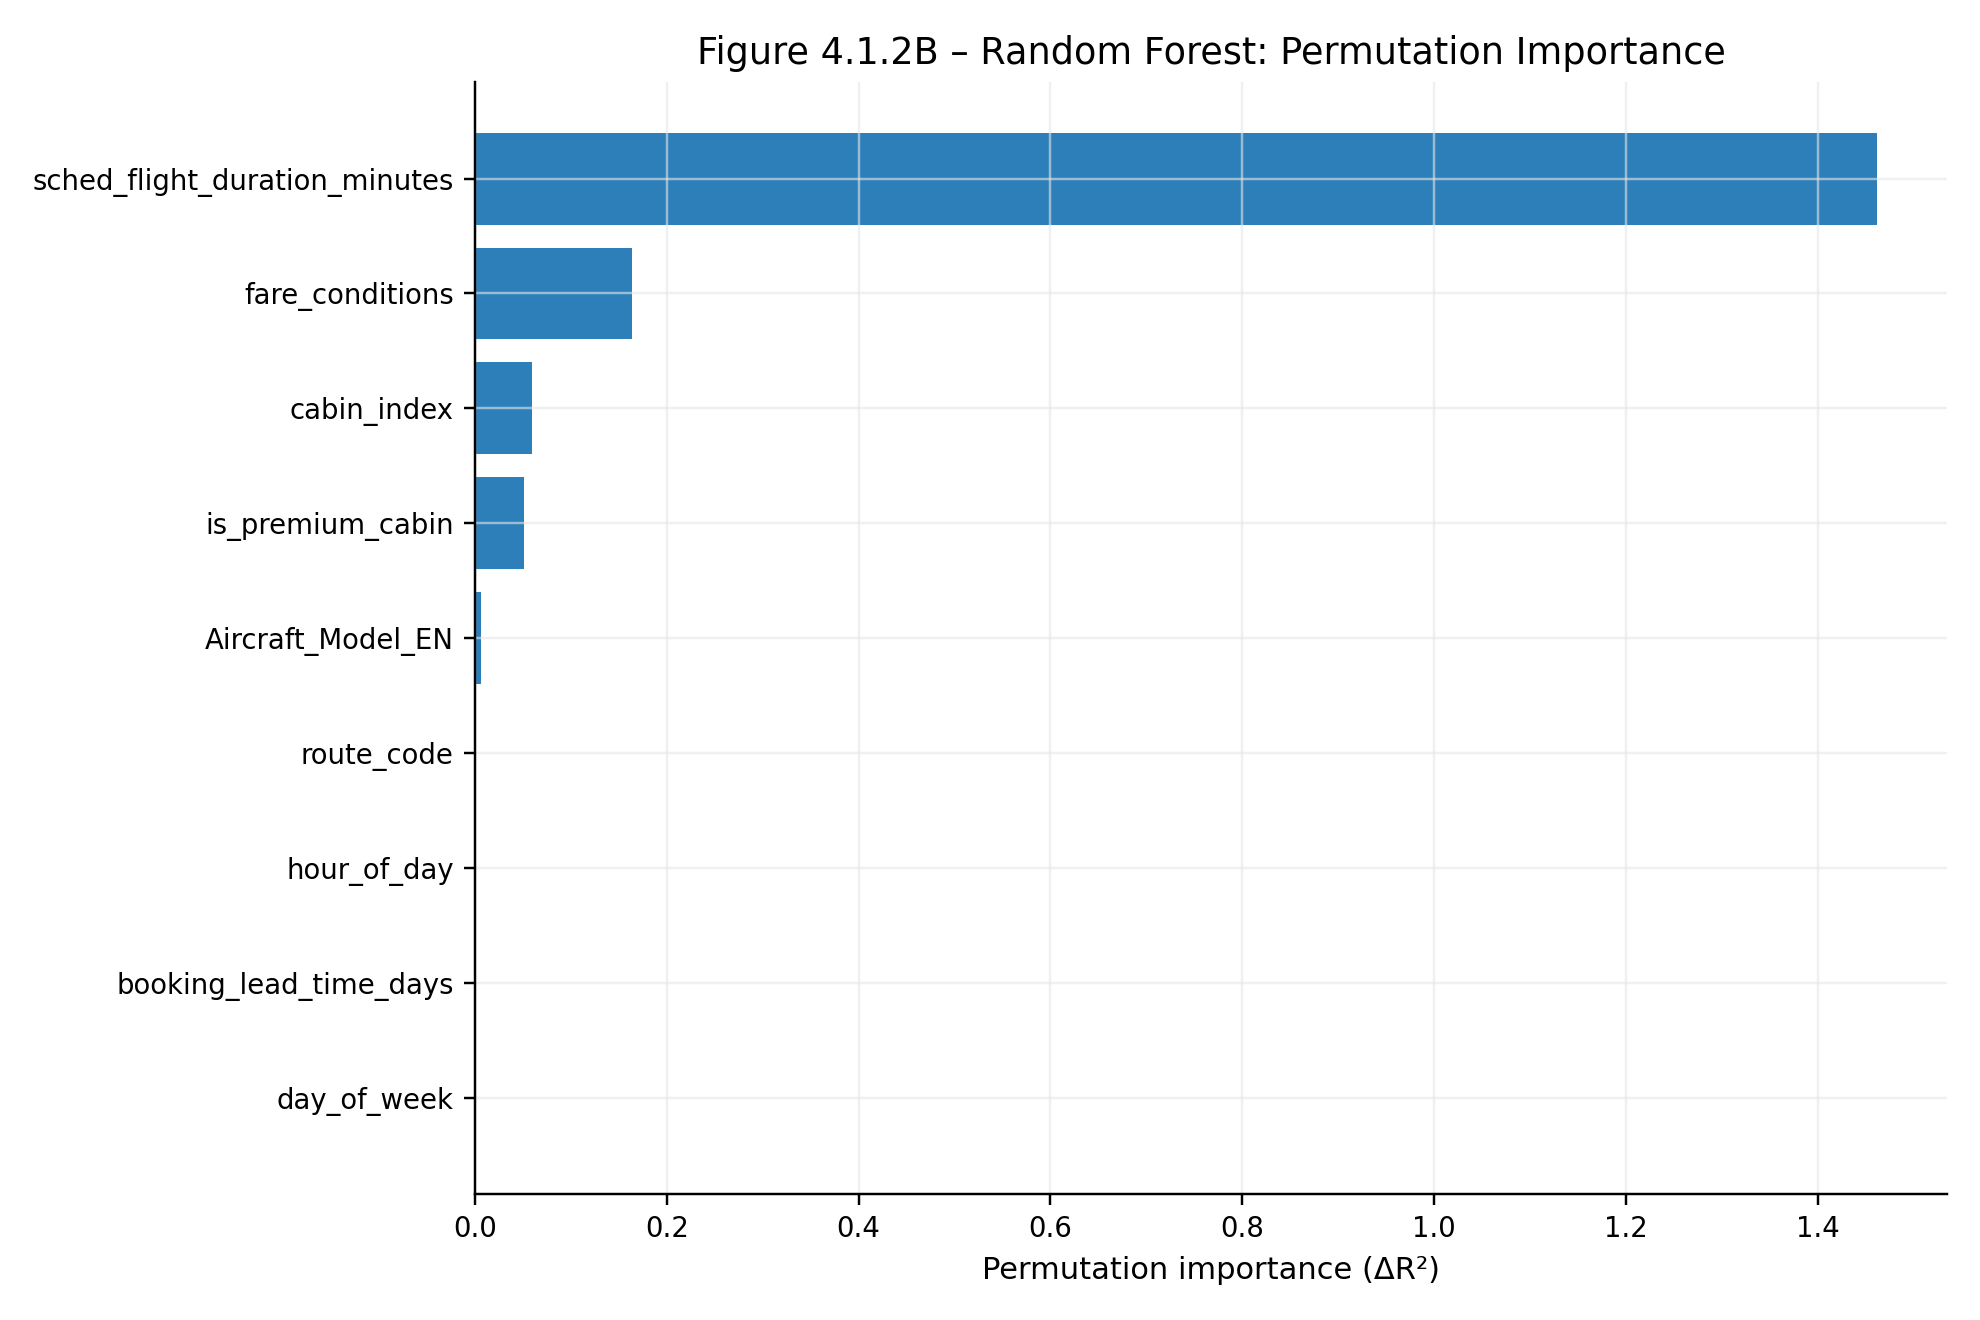

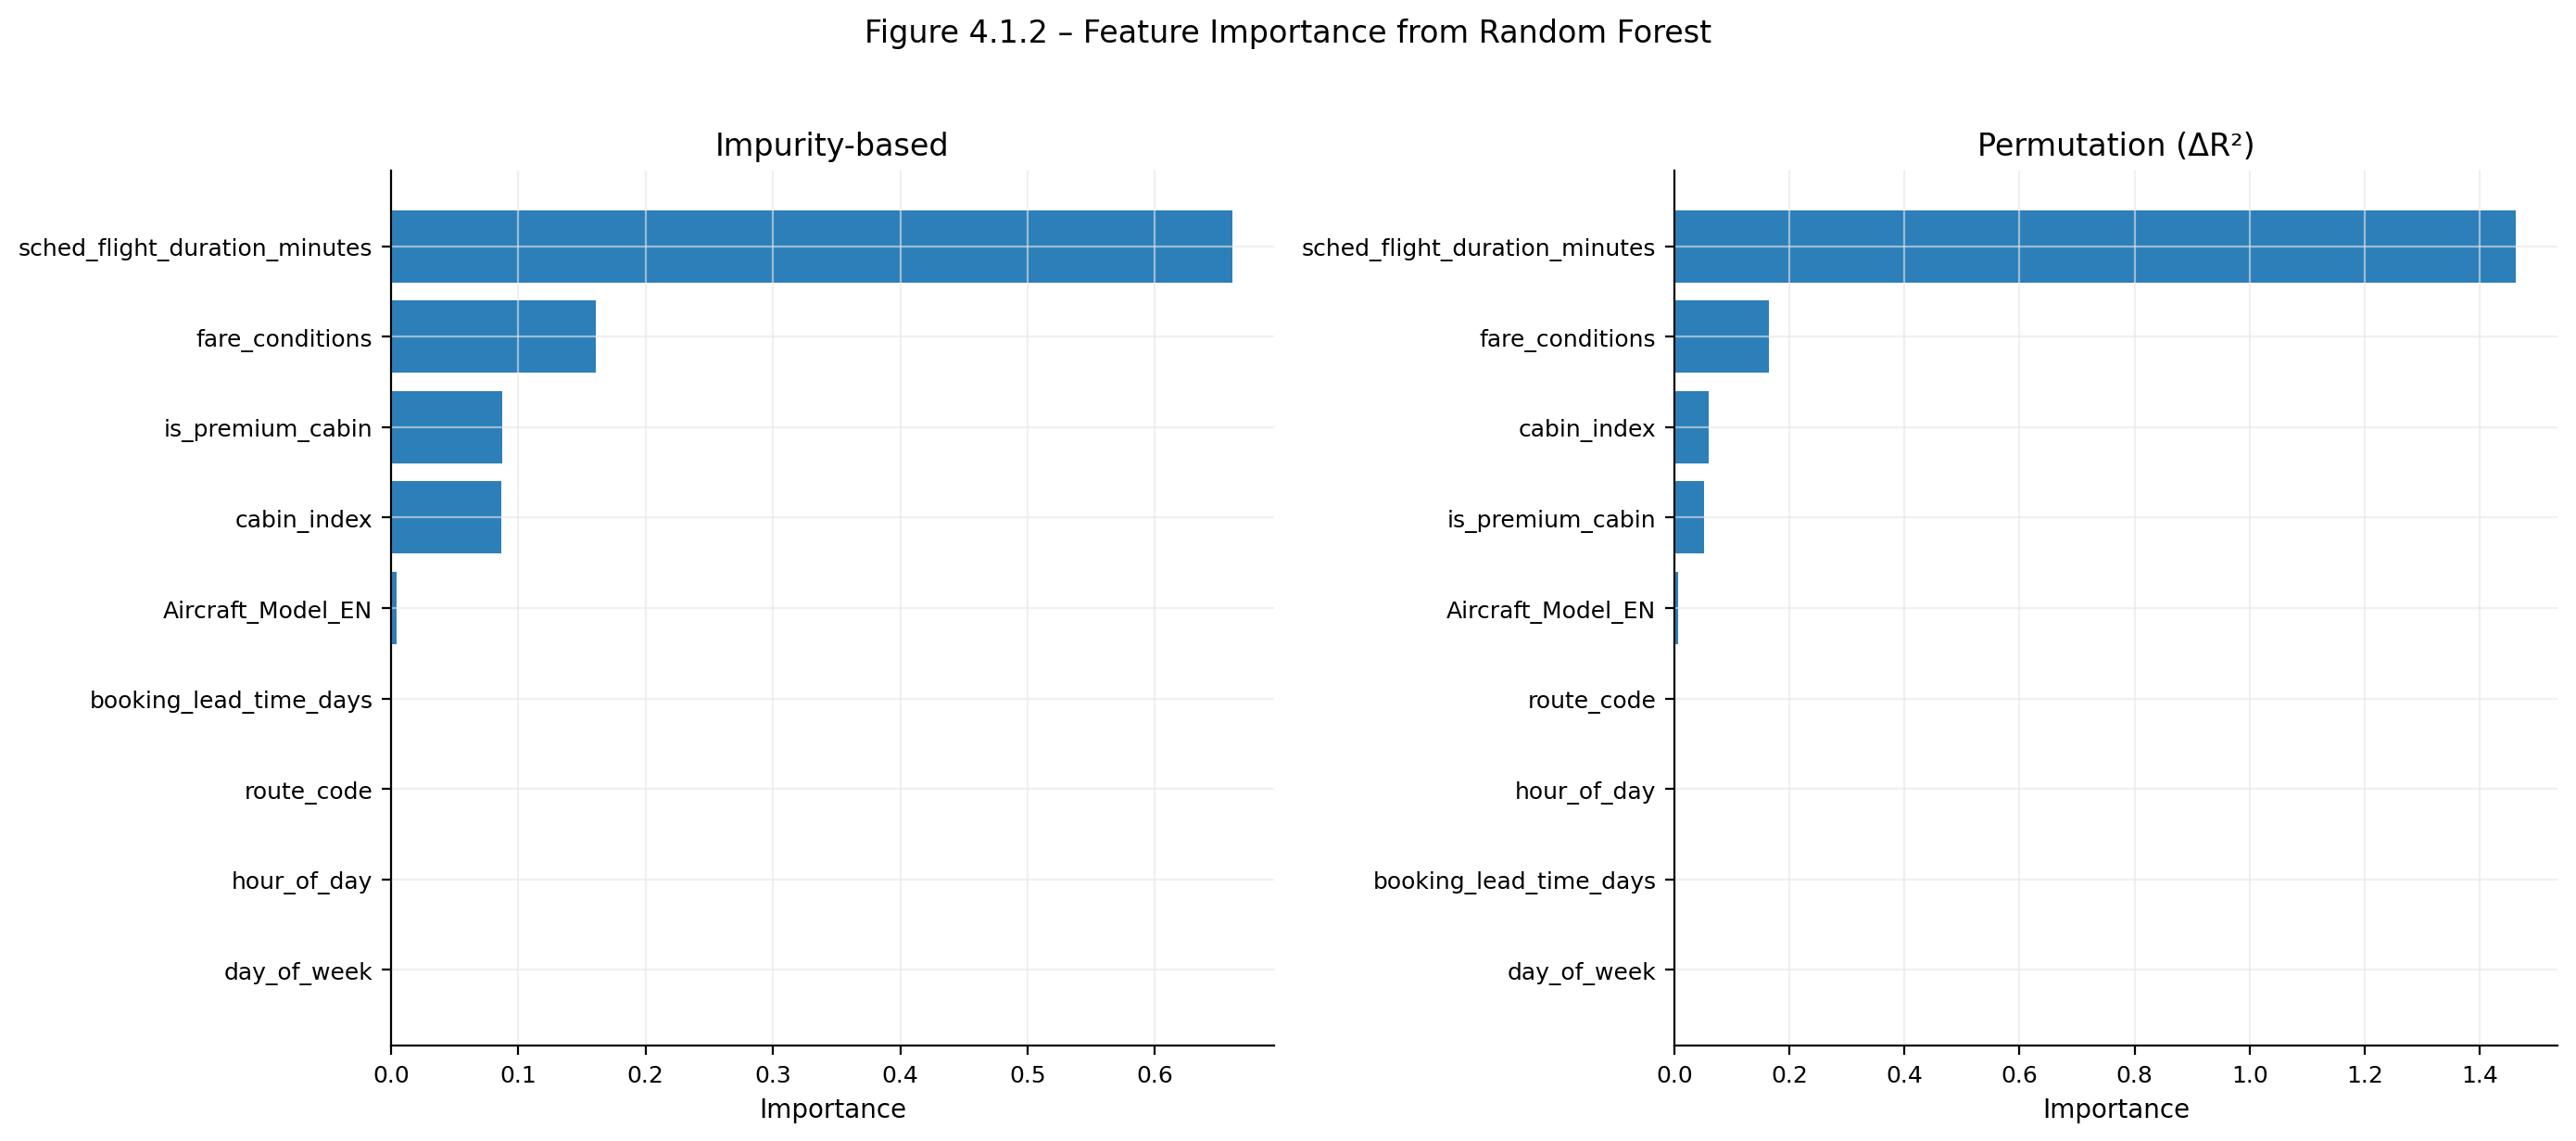

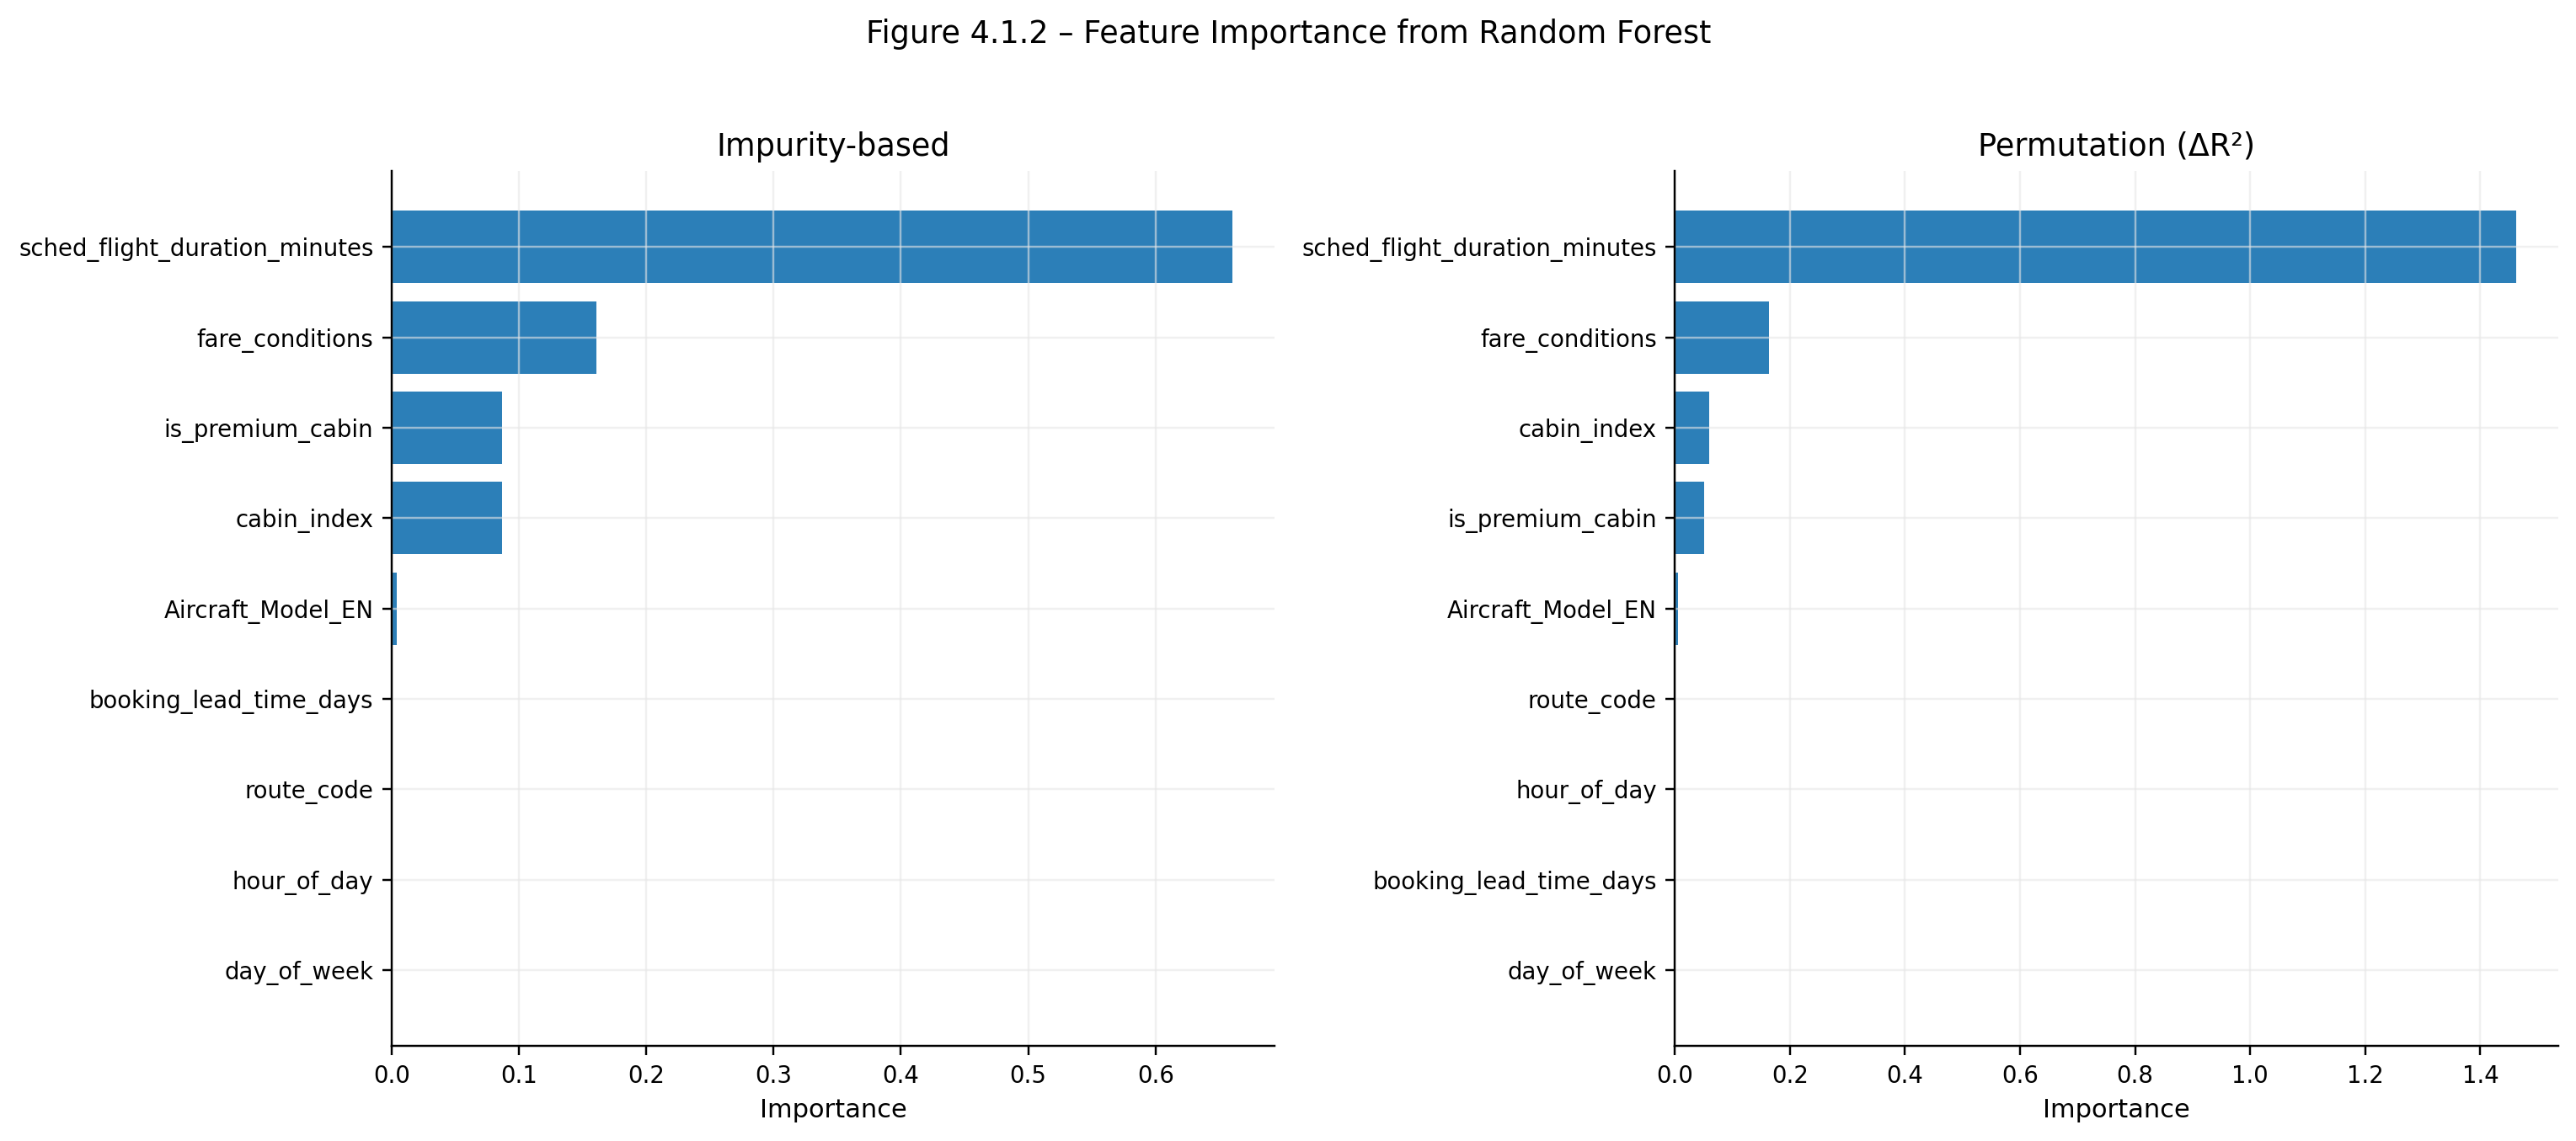

Final shortlisted features (9): ['Aircraft_Model_EN', 'booking_lead_time_days', 'cabin_index', 'day_of_week', 'fare_conditions', 'hour_of_day', 'is_premium_cabin', 'route_code', 'sched_flight_duration_minutes']


In [6]:
X_train_rf = subsample(X_train, 200_000)
y_train_rf = y_train.loc[X_train_rf.index]
pipe_rf.fit(X_train_rf, y_train_rf)

ohe_pipe = pipe_rf.named_steps["pre"].named_transformers_.get("cat")
enc_names = []
if ohe_pipe is not None:
    enc = ohe_pipe.named_steps["ohe"]
    if hasattr(enc, "get_feature_names_out"):
        enc_names = list(enc.get_feature_names_out(cat_cols))
    else:
        enc_names = list(enc.get_feature_names(cat_cols))

feat_names_enc = list(num_cols) + enc_names
imp_enc = pipe_rf.named_steps["rf"].feature_importances_

def to_original(name):
    for c in cat_cols:
        if name.startswith(c + "_"):
            return c
    return name

imp_df = (pd.DataFrame({"encoded_feature": feat_names_enc, "importance": imp_enc})
          .assign(feature=lambda d: d["encoded_feature"].map(to_original))
          .groupby("feature", as_index=False)["importance"].sum()
          .sort_values("importance", ascending=False)
          .reset_index(drop=True))

imp_df.to_csv(TAB_DIR/"table_4_1_0_rf_impurity_all.csv", index=False)

top25_imp = imp_df.head(25)
fig1, ax1 = plt.subplots(figsize=(9, 6))
ax1.barh(top25_imp["feature"][::-1], top25_imp["importance"][::-1])
ax1.set_xlabel("RF impurity-based importance")
ax1.set_title("Figure 4.1.2A – Random Forest: Impurity-based Importance")
fig1.tight_layout(); fig1.savefig(FIG_DIR/"figure_4_1_2_impurity.png", dpi=220)
plt.show()
display(Image(filename=str(FIG_DIR/"figure_4_1_2_impurity.png")))

X_test_perm = subsample(X_test, 50_000)
y_test_perm = y.loc[X_test_perm.index]
perm = permutation_importance(
    pipe_rf, X_test_perm, y_test_perm,
    n_repeats=5, random_state=42, n_jobs=-1, scoring="r2"
)
perm_df = (pd.DataFrame({"feature": X_test_perm.columns, "perm_importance": perm.importances_mean})
           .sort_values("perm_importance", ascending=False)
           .reset_index(drop=True))
perm_df.to_csv(TAB_DIR/"table_4_1_0_rf_permutation_all.csv", index=False)

top25_perm = perm_df.head(25)
fig2, ax2 = plt.subplots(figsize=(9, 6))
ax2.barh(top25_perm["feature"][::-1], top25_perm["perm_importance"][::-1])
ax2.set_xlabel("Permutation importance (ΔR²)")
ax2.set_title("Figure 4.1.2B – Random Forest: Permutation Importance")
fig2.tight_layout(); fig2.savefig(FIG_DIR/"figure_4_1_2_permutation.png", dpi=220)
plt.show()
display(Image(filename=str(FIG_DIR/"figure_4_1_2_permutation.png")))

fig_combo, (axL, axR) = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
axL.barh(top25_imp["feature"][::-1], top25_imp["importance"][::-1]); axL.set_title("Impurity-based"); axL.set_xlabel("Importance")
axR.barh(top25_perm["feature"][::-1], top25_perm["perm_importance"][::-1]); axR.set_title("Permutation (ΔR²)"); axR.set_xlabel("Importance")
fig_combo.suptitle("Figure 4.1.2 – Feature Importance from Random Forest", y=1.02)
fig_combo.tight_layout()
fig_combo.savefig(FIG_DIR/"figure_4_1_2_random_forest_both.png", dpi=220, bbox_inches="tight")
plt.show()
display(Image(filename=str(FIG_DIR/"figure_4_1_2_random_forest_both.png")))

final_shortlist = sorted(set(top25_imp["feature"]) | set(top25_perm["feature"]))
pd.Series(final_shortlist, name="final_features").to_csv(TAB_DIR/"final_feature_shortlist.txt", index=False)
print(f"Final shortlisted features ({len(final_shortlist)}):", final_shortlist)


Feature,VIF
is_premium_cabin,25.869434
cabin_index,25.866021
hour_of_day,1.013422
sched_flight_duration_minutes,1.013394
booking_lead_time_days,1.000792
day_of_week,1.000265


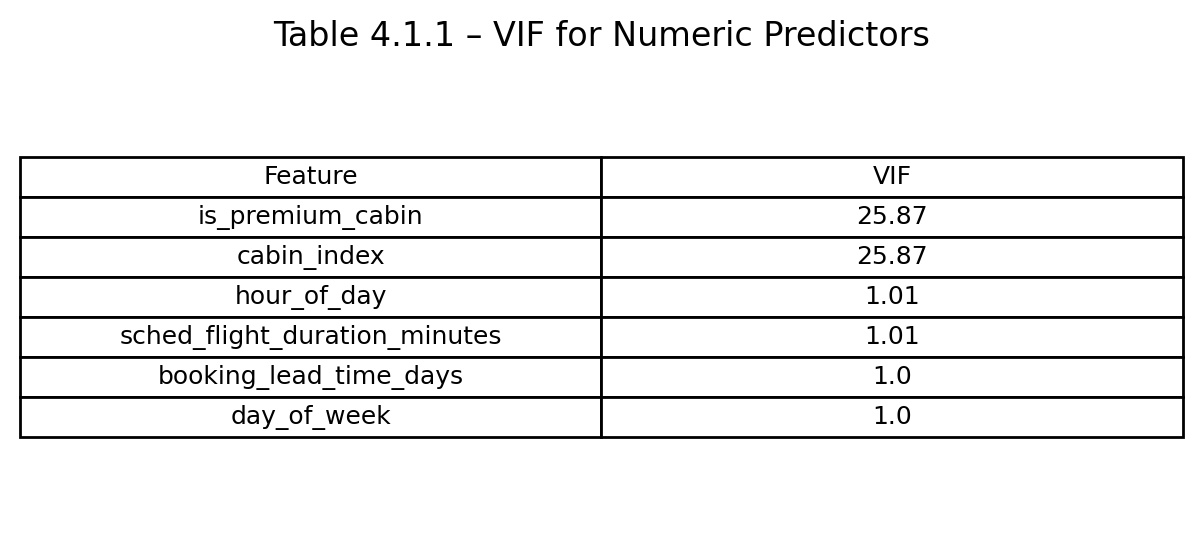

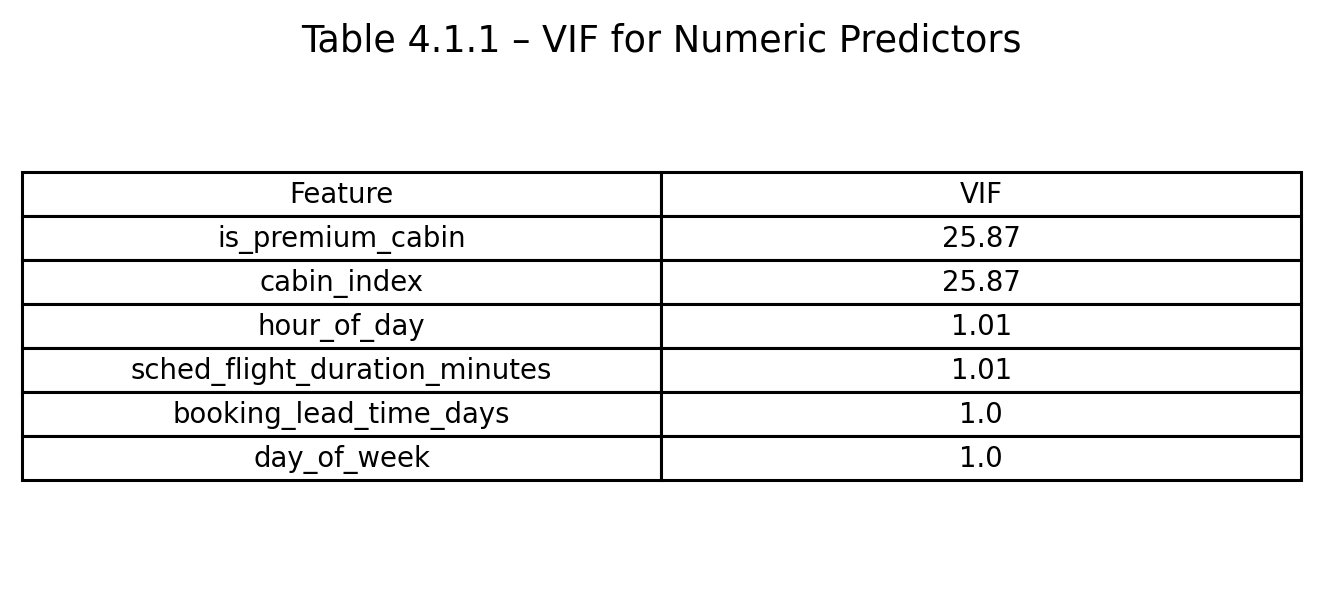


Saved files:
  figures/figure_4_1_2_impurity.png
  figures/figure_4_1_2_permutation.png
  figures/figure_4_1_2_random_forest_both.png
  figures/figure_4_1_1_vif.png
  tables/table_4_1_0_rf_impurity_all.csv
  tables/table_4_1_0_rf_permutation_all.csv
  tables/table_4_1_1_vif.csv
  tables/final_feature_shortlist.txt


In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 仅对数值列计算 VIF（先中位数填补再标准化）
num_imputer = SimpleImputer(strategy="median")
X_num = pd.DataFrame(num_imputer.fit_transform(X[num_cols]), columns=num_cols)
scaler = StandardScaler()
X_num_sc = pd.DataFrame(scaler.fit_transform(X_num), columns=num_cols)

vif_rows = [{"Feature": col, "VIF": float(variance_inflation_factor(X_num_sc.values, i))}
            for i, col in enumerate(X_num_sc.columns)]
vif_df = pd.DataFrame(vif_rows).sort_values("VIF", ascending=False).reset_index(drop=True)

# 在 Jupyter 显示 + 导出 CSV
try:
    display(vif_df.style.hide(axis="index"))
except Exception:
    display(vif_df)

vif_df.to_csv(TAB_DIR/"table_4_1_1_vif.csv", index=False)

# 保存 PNG 表格（便于粘贴 Word）
fig_h = 0.8 + 0.35*len(vif_df)
fig, ax = plt.subplots(figsize=(7.5, fig_h))
ax.axis("off")
tbl = ax.table(cellText=vif_df.round(2).values, colLabels=vif_df.columns,
               loc="center", cellLoc="center")
tbl.auto_set_font_size(False); tbl.set_fontsize(9); tbl.scale(1, 1.2)
plt.title("Table 4.1.1 – VIF for Numeric Predictors", pad=10)
fig.savefig(FIG_DIR/"figure_4_1_1_vif.png", dpi=220, bbox_inches="tight")
plt.show()
display(Image(filename=str(FIG_DIR/"figure_4_1_1_vif.png")))

print("\nSaved files:")
print("  figures/figure_4_1_2_impurity.png")
print("  figures/figure_4_1_2_permutation.png")
print("  figures/figure_4_1_2_random_forest_both.png")
print("  figures/figure_4_1_1_vif.png")
print("  tables/table_4_1_0_rf_impurity_all.csv")
print("  tables/table_4_1_0_rf_permutation_all.csv")
print("  tables/table_4_1_1_vif.csv")
print("  tables/final_feature_shortlist.txt")
